# Mutualism IBM

In [285]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

## Resource class

In [286]:
class Resource():

    def __init__(self, ty:str, C:float=100):
        """
        Resource - particle used for cell functions   
        -------------------------------------------
        ty (str): resource type
        C (float): concentration of resource
        """
        self.type = ty 
        self.C = C

    def consume(self, m):
        """
        Consume amount m of this resource  
        """

        self.C -= m

        return None

    
        

## Cell class

In [287]:
class Cell():

    def __init__(self, ty:str=None, trait:float=None, R:float=1.0, size:float=1.0) -> None:
        """ 
        Cell - basic individual unit
        ----------------------------
        ty (str): type or allele of cell (Default: None)
        trait (float): primary trait value (Default: None)
        R (float): endogenous resources
        size (float): cell size
        """
        assert ty in ['A', 'B', None], "ty should be A or B"
        assert trait is None or trait >= 0 and trait <= 1, "trait should be on interval [0,1]"

        self.req = set(['C'])
        self.type = self.init_ty(ty)
        self.trait = self.init_trait(trait)
        self.R = R
        self.size = size
        self.mt = 0.5 # cost of self maintenance
        self.g = 0.2 # growth constant
        self.rp = 0.1 # resource production constant 
        # self.supplement()
        self.d = 0.01 # base probability of dormancy
        self.isDepleted = False
        self.isDividing = False

    def init_ty(self, ty) -> str:
        """  
        Initialize cell type
        """
        if ty is None: # default behavior, else return provided value
            
            ty = np.random.choice(['A', 'B'])

            if ty=='A': self.req.add('B')
            elif ty=='B': self.req.add('A')
            
            
        return ty
    
    def init_trait(self, trait, mutate=False) -> float:
        """ 
        picks a random trait value if not specified 
        """
        if trait is None: # default behavior, else return provided value

            trait = np.random.uniform()
        
        elif mutate:
            pass

        return trait
    
    def depleted(self) -> None:
        self.isDepleted = self.R <= 0
        # if self.R <= 0: print('empty')
        return None

    def maintenance(self) -> None:
        self.R -= min(self.R, self.mt)
        return None
    
    def growth(self) -> None:
        g = min(self.g, self.R)
        self.R -= g
        self.size += g
        return None
    
    def division(self) -> None:
        if self.R < 0:
            
            p = self.R/(1+self.R) * self.size/(1+self.size) # probability of cell division

            if np.random.binomial(1, p) == 1:
                self.isDividing = True

        return None

    def divide(self) -> None:

        self.size /= 2
        self.R /= 2
        self.isDividing = False 

        return None
        
    def produce(self) -> float:
        s = self.trait*self.R
        return max(s, 0)
    
    def uptake(self, resource) -> None:
        """  
        Intake resources
        """

        self.R += resource

        return None
    
    def timestep(self, resource) -> None:
        # maintenance
        self.maintenance()

        # growth
        self.growth()

        # metabolite production
        self.R -= self.produce()

        # division
        self.division()

        self.depleted()

        # dormancy
        if not self.isDividing:
            self.d = 1/(1+self.R) # probability of going dormant

        return None
    
    
    
    def dorm(self) -> None:
        """ 
        calculate probability of going dormant
        prob = 0 if the cell is dividing
        """

        if not self.isDividing:
            self.d = 1/(1+self.R)
        
        else:
            self.d = 0

        return None
    
    # def production(self, resources:dict):
    #     """  
    #     Amount of secondary resource this cell produces
    #     """

    #     return self.trait * self.fitness(resources)

    # def supplement(self) -> None:
    #     """  
    #     Required resources for the cell
    #     Current version is basic
    #     """
    #     self.sup = set()

    #     if self.type=='A':
    #         self.sup.add('R_a')

    #     elif self.type=='B':
    #         self.sup.add('R_b')

    #     return None
    
    # def fitness(self, resources:dict) -> float:
    #     """
    #     Absolute fitness W of cell based on available resources
    #     """
    #     req = self.req

    #     # initialize
    #     W = 0 
    #     W_req = 0 # required
    #     W_sup = 0 # supplemental

    #     for resource, R in resources.items(): # for all  resources

    #         if resource in req:  # if required
    #             W_req *= R/(50 + R)
        
    #         elif True: # if supplemental

    #             W_sup *= R/(50 + R)


    #     if W_req==0: 
            
    #         W = 0 # if no required resources, can't grow 
        
    #     else:
    #          W = W_req + W_sup

    #     return W

        

## Population class

In [288]:
class Population():
    """ 
    Population - collection of cells
    --------------------------------
    cells (list) - list of Cell() objects
    N (int, default=100) - population size 
    """
    def __init__(self, cells:list, resources:dict, N:int=100) -> None:
        # try
        self.__update(cells)
        self.dormant = list()
        self.resources = resources  

    def timestep(self) -> None:
        """
        Processes that occur every timestep 
        """

        # 1 resuscitate
        resc = self.resc()
        cells = np.array(self.cells + resc) # bank of cells comes prev timestep and current resuscitated cells

        # 2 internal cell processes

        m = 1

        order = np.random.choice(range(self.N), size=self.N) # randomize order of cells

        for i in order:

            cell = cells[i]
            a = cell.R

            cell.maintenance()
            cell.growth()

            R = cell.produce()
            cell.R -= R

            self.resources[cell.type] += R

            cell.division()
            

            for r in cell.req: # for all resources this cell uses

                if self.resources[r] > m:

                    cell.R += m
                    self.resources[r] -= m

            cell.depleted()
                  
        
        # 3 pick next gen
        cells = np.array(cells) # convert for slicing
        
        # cells without resources die
        notDepleted = np.array([not cell.isDepleted for cell in cells])
        cells = cells[notDepleted]

        isDividing = np.array([cell.isDividing for cell in cells])
        daughters = [self.daughterCell(cell) for cell in cells[isDividing]]

        next_gen = list(cells) + daughters
        # weights = self.weights(cells, resources)
        # new_cells = list(np.random.choice(cells, size=self.N, replace=True, p=weights))
        
        # 4 dormancy
        dorm = self.dorm()
        self.dormant += dorm # add cells to dormancy list
        self.__update(next_gen)
        

        for resource, R in self.resources.items():
            if R <= 0:
                self.resources[resource] = 0

        return None

    def freq(self, ty) -> float:
        """
        Returns frequency of given allele (ty) in pop  
        """
        return self.types.count(ty)/len(self.cells)
    
    def density(self, ty) -> int:
        """
        Returns frequency of given allele (ty) in pop   
        """
        return self.types.count(ty)

    def trait_mean(self) -> float:
        """
        Takes mean trait of pop 
        """
        return np.mean(self.traits)
    
    def weights(self, cells, resources) -> np.array:
        """ 
        Return probabilities that each cell is selected for the next timestep
        """
        W = [ cell.fitness(resources) for cell in cells ] # absolute fitness for all

        sumW = np.sum(W)

        if sumW == 0:
            return None

        weights = W/np.sum(W) # relative fitness, kinda
        
        if np.isnan(np.sum(weights)):
            weights = None

        return weights
    
    def daughterCell(self, cell:Cell)->Cell:
        cell.divide()
        daughter = deepcopy(cell)
        return daughter
    
    def dorm(self, responsive:bool=False) -> list:
        """ 
        Select cells to enter dormancy
        """
        cells = self.cells
        
        if responsive:
            # pD = np.array([ cell.d for cell in cells ]) # array of dormancy probabilities
            pD = np.array([ cell.d for cell in cells ]) # array of dormancy probabilities
            rng = np.random.uniform(size = self.N) # cell becomes dormant if random num is smaller than pD
            isDormant = pD > rng  
            dormant = np.array(cells)[isDormant] # filter by the cells that should be dormant

        else:
            pD = 0.01 # per cell probability of going dormant
            N = len(cells)
            D = np.random.binomial( n=N, p=pD ) # the number of cells that go into dormancy is binomially distributed
            dormant = np.random.choice(cells, size=D, replace=False) # pick which cells go dormant

        for cell in dormant: # remove dormant cells from active population
            self.cells.remove(cell)

        return list(dormant)
    
    def resc(self) -> list:
        """
        Pick cells to resuscitate from dormancy
        """
        pR = 0.01 # per cell prob of resuscitating
        D = len(self.dormant) # number of dormant cells
        R = np.random.binomial( n=D, p=pR )
        resc = np.random.choice(self.dormant, size=R, replace=False)

        for cell in resc: # remove resuscitated cells from dormant population
            self.dormant.remove(cell)

        return list(resc)
    
    def __update(self, cells) -> None:
        """ update population attributes """
        self.types = [cell.type for cell in cells]
        self.traits = np.array([cell.trait for cell in cells])
        self.cells = cells
        self.N = len(cells)
        return None

## Make populations

In [300]:
N_i = 100 # initial N
t_max = 100

# R_i = {
#     'A': Resource(ty='A', C=0),
#     'B': Resource(ty='B', C=0),
#     'C': Resource(ty='C', C=100)
# }

R_i = {
    'A': 0,
    'B': 0,
    'C': 100
}
pop = Population([ Cell() for i in range(N_i) ], R_i)

## simulate

In [301]:
freqA = [pop.freq('A')]
mean_trait = [pop.trait_mean()]
D = [len(pop.dormant)]
Na = [pop.density('A')]
Nb = [pop.density('B')]
r_a = [R_i['A']]
r_b = [R_i['B']]
r_c = [R_i['C']]

for i in range(t_max):

    pop.timestep()

    pop.resources['C'] += 100
    
    freqA.append(pop.freq('A'))
    Na.append(pop.density('A'))
    Nb.append(pop.density('B'))
    mean_trait.append(pop.trait_mean())
    D.append(len(pop.dormant))
    r_a.append(pop.resources['A'])
    r_b.append(pop.resources['B'])
    r_c.append(pop.resources['C'])



## plot

### densities over time

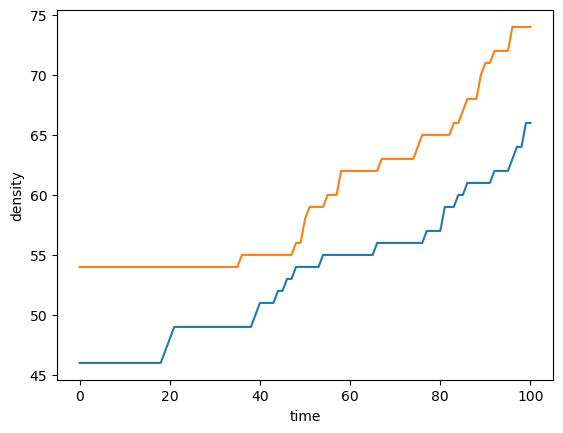

In [302]:
fig, ax = plt.subplots()
ax.plot(range(t_max+1), Na)
ax.plot(range(t_max+1), Nb)
ax.set_xlabel('time')
ax.set_ylabel('density')
plt.show()

### p(a) over time

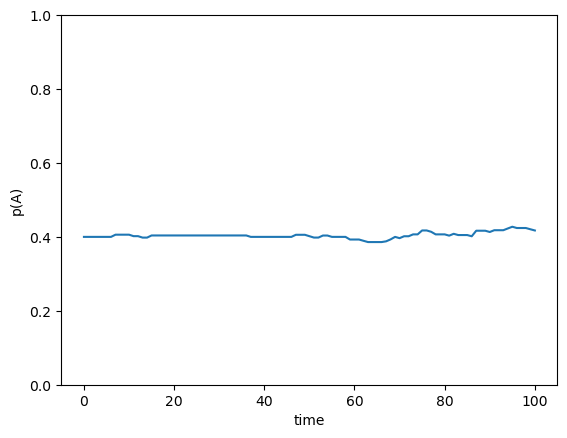

In [292]:
fig, ax = plt.subplots()
ax.plot(range(t_max+1), freqA)
ax.set_xlabel('time')
ax.set_ylabel('p(A)')
ax.set_ylim(0,1)
plt.show()

### Mean Trait Value

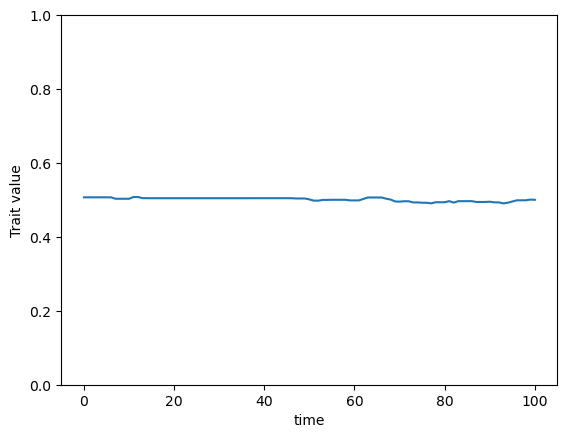

In [293]:
fig, ax = plt.subplots()
ax.plot(range(t_max+1), mean_trait)
ax.set_xlabel('time')
ax.set_ylabel('Trait value')
ax.set_ylim(0,1)
plt.show()

### Number of dormant cells over time

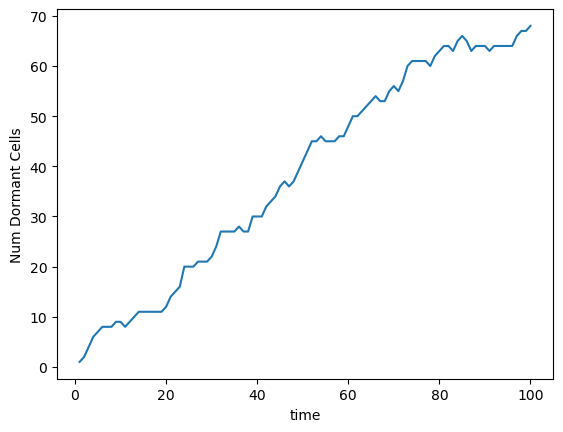

In [294]:
fig, ax = plt.subplots()
ax.plot(range(1, t_max+1), D[1:len(D)])
ax.set_xlabel('time')
ax.set_ylabel('Num Dormant Cells')
plt.show()

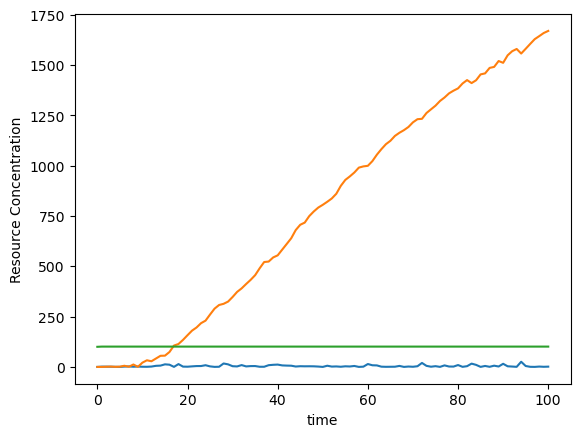

In [295]:
fig, ax = plt.subplots()
ax.plot(range(t_max+1), r_a)
ax.plot(range(t_max+1), r_b)
ax.plot(range(t_max+1), r_c)
ax.set_xlabel('time')
ax.set_ylabel('Resource Concentration')
# ax.set_yscale('log')
plt.show()